# Titanic Survival

# 1. Variable description

* survival: Survival (0 = No; 1 = Yes)
* pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name: Name
* sex: Sex
* age: Age
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* ticket: Ticket Number
* fare: Passenger Fare
* cabin: Cabin
* embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# 2. Goal
Use 891 train data with survival data, predict survivals for 421 test data. 

# 3. Summary
Overall survival rates relations:
- ** female > male ** 
- ** 1st class > 3rd class ** 
- ** child > senior ** 
- ** with family > single ** 
- ** high fare > low fare  ** 

# 4. Explore Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

## Basic statistics

In [3]:
df.shape

(891, 12)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

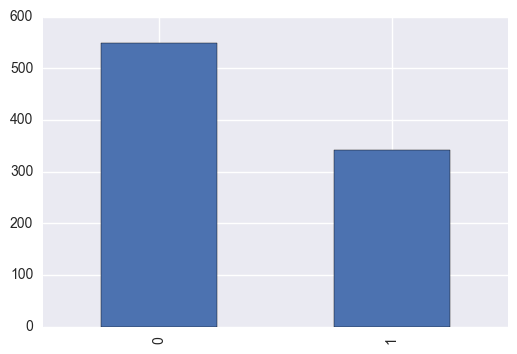

In [6]:
survived_cnt = df.Survived.value_counts()
survived_cnt.plot(kind='bar')

In [7]:
print('Overall Non-Survival Rate = %.1f%%' %(survived_cnt[0]/(survived_cnt[0]+survived_cnt[1])*100))

Overall Non-Survival Rate = 61.6%


## Sex

- Females have significantly higher survival rate. 

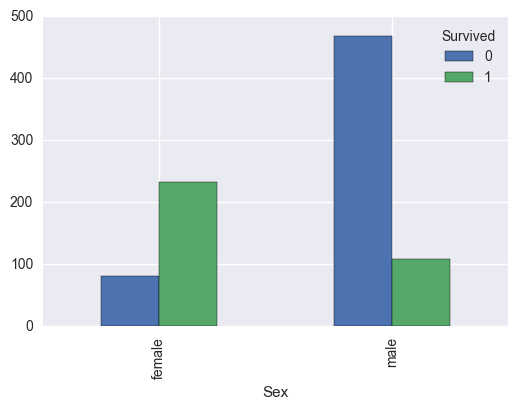

In [8]:
df.groupby(['Sex', 'Survived']).size().unstack().plot(kind='bar')

## PClass

- Lower socio-economic status (PClass=3) has significantly lower survival rate. 

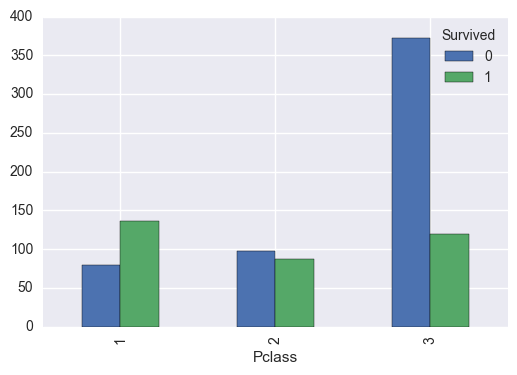

In [9]:
df.groupby(['Pclass', 'Survived']).size().unstack().plot(kind='bar')

## Name/Title

- We use the title from Name.
- Miss and Mrs have a significantly higher survival rate, while Mr has a lower survival rate. 
- Keep in mind that Title depends on 'Age', 'Sex', and 'Family Size'. It is not surprising to see 'Mr' has lower survival rate than 'Miss' and 'Mrs'. 

In [10]:
# add title
def getTitle(s):
    first,last = s.split(',')
    
    last = last.strip()
    title = ''
    if last.find('.') != -1:
        title = last.split('.')[0]
        
    if title not in ['Mr', 'Mrs', 'Miss', 'Master']:
        return 'Else'
    return title

df['title'] = df.Name.map(getTitle);

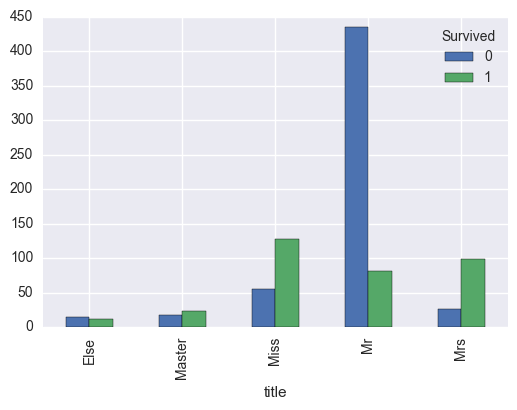

In [11]:
df.groupby(['title', 'Survived']).size().unstack().plot(kind='bar')

## Family Size 

- Having 1-2 siblings, or 1-2 Parch seems to increase the chance of survival. 
- It may be surmized by a single variable 'Family Size'.
- Singles have a disadvantage over 2-4 size families.

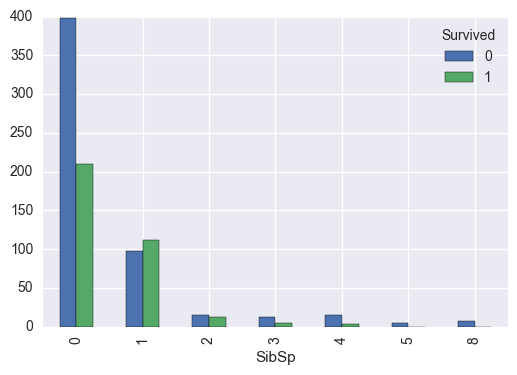

In [12]:
df.groupby(['SibSp', 'Survived']).size().unstack().plot(kind='bar')

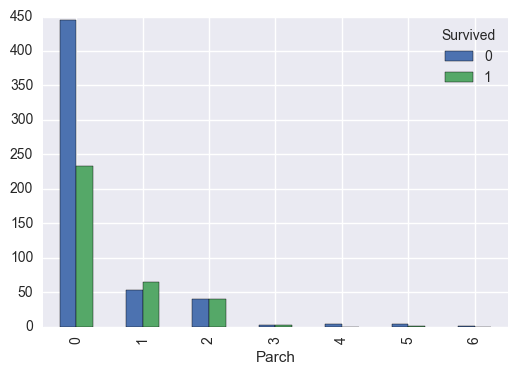

In [13]:
df.groupby(['Parch', 'Survived']).size().unstack().plot(kind='bar')

In [14]:
# add family size
df['familySize'] = df.SibSp + df.Parch
df['familySize'] = df['familySize'].map(lambda x: x+1)

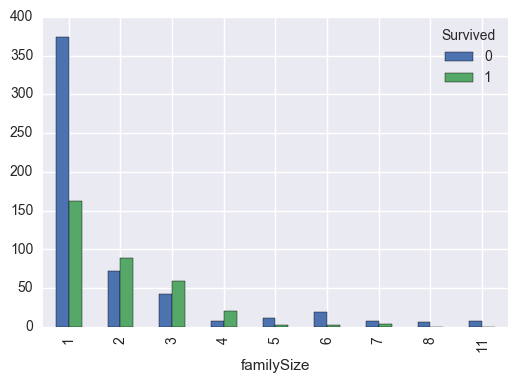

In [15]:
df.groupby(['familySize', 'Survived']).size().unstack().plot(kind='bar')

## Fare

- We see that the survival rate is higher for Fare > ~20

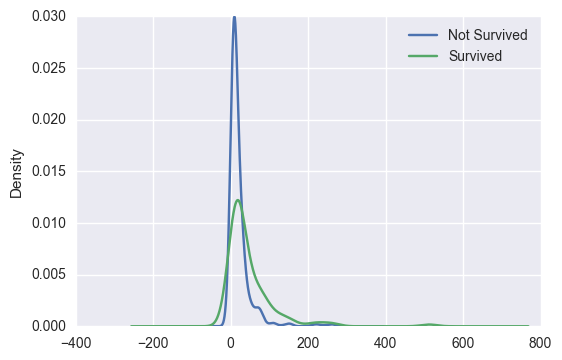

In [16]:
fares = df.Fare
mask_survived = (df.Survived == 1)
fares[~mask_survived].plot(kind='kde', label='Not Survived', legend=True)
fares[mask_survived].plot(kind='kde', label='Survived', legend=True)

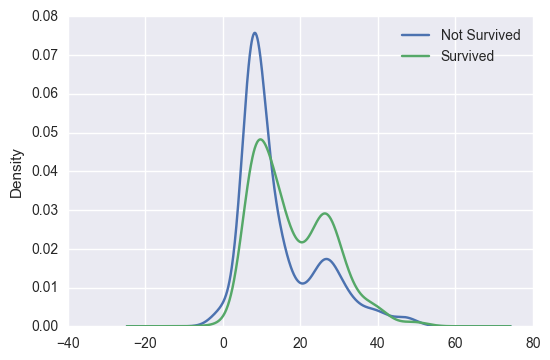

In [17]:
plot_data = df.Fare[df.Fare < 50]
mask_survived = (df.Survived == 1)
plot_data[~mask_survived].plot(kind='kde', label='Not Survived', legend=True)
plot_data[mask_survived].plot(kind='kde', label='Survived', legend=True)

## Age

- 20% of data are missing.
- Children of age 0-18 have higher survival rate than average, while old people of age 60-100 have lower survival rate. 
- People with 'Missing age' have lower survival rate, indicating missing values may come from missing people from the accident.

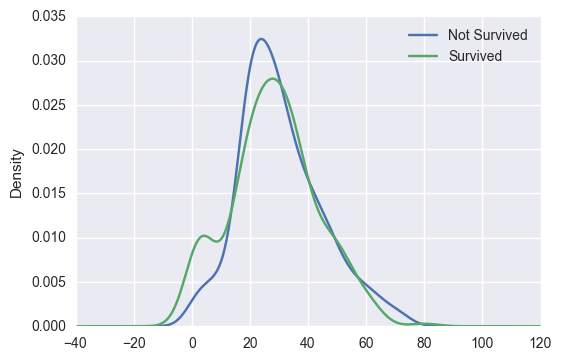

In [18]:
plot_data = df.Age[df.Age.notnull()]
mask_survived = (df.Survived == 1)
plot_data[~mask_survived].plot(kind='kde', label='Not Survived', legend=True)
plot_data[mask_survived].plot(kind='kde', label='Survived', legend=True)

In [19]:
df.Age.fillna(1000, inplace=True)
df['ageCat'] = pd.cut(df['Age'], bins=[0,18,30,60, 100, 2000])

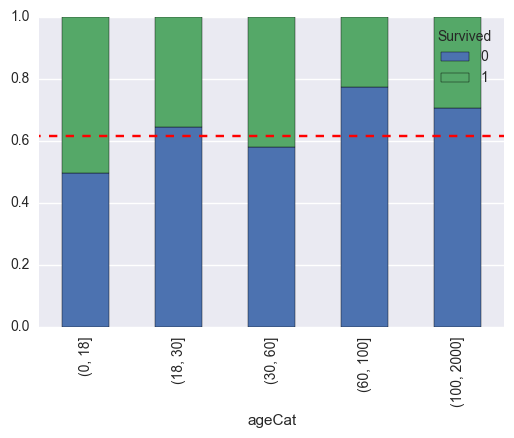

In [20]:
gp_a_s = df.groupby(['ageCat', 'Survived']).size().unstack()
gp_a_s.div(gp_a_s.sum(1), axis=0).plot(kind='bar', stacked=1)

overall_avg = 0.616
plt.plot([-1,6], [overall_avg,overall_avg],'r--')

# Cabin

- 77% of data are missing. 
- 'Having information' increases the chance of survival. In other words, missing information is more likely to be caused by missing people from the accident. 

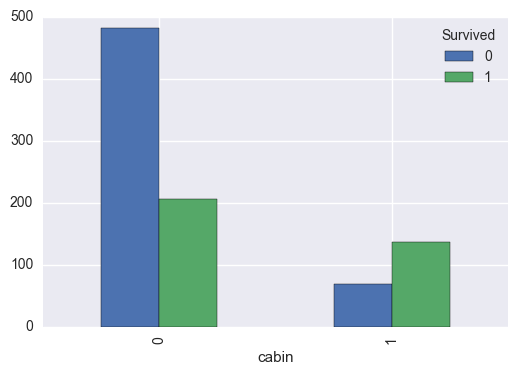

In [21]:
df['cabin'] = 0
df.loc[df.Cabin.notnull(), 'cabin'] = 1
df.groupby(['cabin', 'Survived']).size().unstack().plot(kind='bar')

# Embark

- 'Embarked from C' indicates higher survival rate.
- Based on Fare, higher survival rate for C is also related to overall higher Fare. 
- Missing Embarked values are likely to be 'C' based on Fare values, but we may delete it anyway because they are only 2 data. 

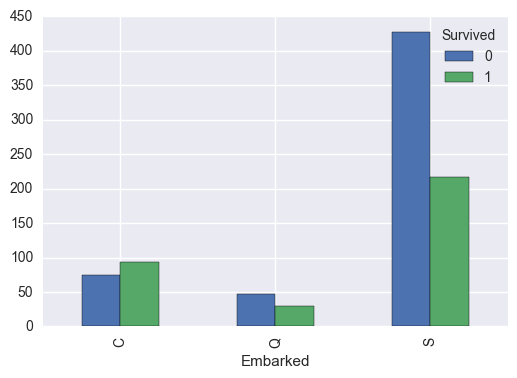

In [22]:
df.groupby(['Embarked', 'Survived']).size().unstack().plot(kind='bar')

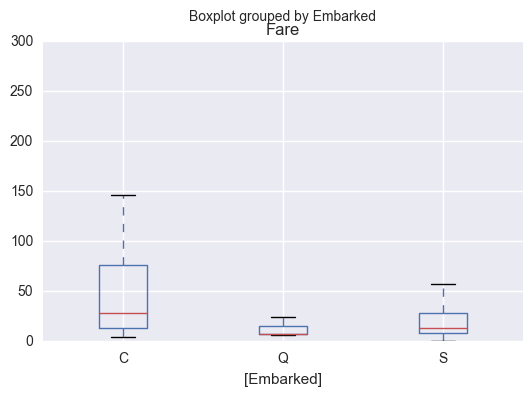

In [23]:
df[['Embarked','Fare']][(df.Fare < 300)].boxplot(by='Embarked')

In [24]:
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,familySize,ageCat,cabin
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,"(30, 60]",1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,"(60, 100]",1


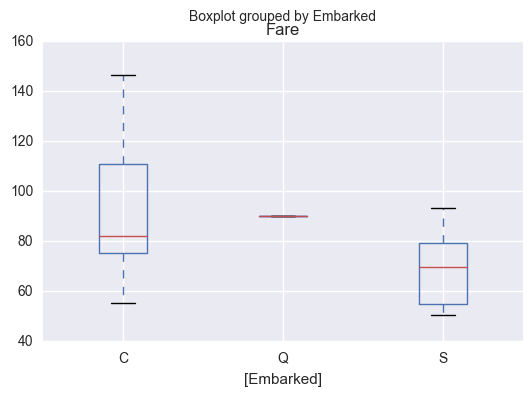

In [25]:
df[['Embarked','Fare']][(df.Fare > 50) & (df.Fare < 150)].boxplot(by='Embarked')